In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('./creditcard.csv')

In [4]:
count_class = pd.value_counts(data['Class'], sort=True)

Text(0,0.5,'Frequency')

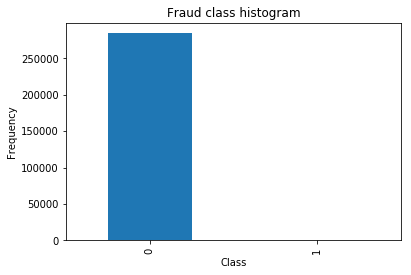

In [5]:
count_class.plot(kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['normAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [7]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

number_records_fraud = len(data[data.Class == 1])
fraud_indicies = np.array(data[data.Class == 1].index)

normal_indicies = data[data.Class == 0].index

random_normal_indicies = np.random.choice(normal_indicies, number_records_fraud, replace=False)
random_normal_indicies = np.array(random_normal_indicies)

under_sample_indicies = np.concatenate([fraud_indicies, random_normal_indicies])
under_sample_data = data.iloc[under_sample_indicies, :]

X_under_sample_data = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_under_sample_data = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [8]:
from sklearn.model_selection import train_test_split
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = \
    train_test_split(X_under_sample_data, y_under_sample_data, test_size=0.3, random_state=0)

print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [9]:
#Recall = TP/(TP+FN)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report

In [17]:
def print_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(5, shuffle=False)
    fold = fold.split(len(y_train_data))
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    result_table = pd.DataFrame(index=range(len(c_param_range)), columns=['c_paramerter', 'Mean recall score'])
    result_table['c_parameter'] = c_param_range
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')
        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)
        # The mean value of those recall scores is the metric we want to save and get hold of.
        result_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
        
        best_c = result_table.loc[result_table['Mean recall score'].idxmax()]['c_paramerter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [18]:
best_c = print_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.9726027397260274
Iteration  2 : recall score =  0.9178082191780822
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.972972972972973
Iteration  5 : recall score =  0.9696969696969697

Mean recall score  0.9666161803148106



D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


TypeError: reduction operation 'argmax' not allowed for this dtype

In [10]:
#Recall = TP/(TP+FN)
# batch_size = 50
# x_ = tf.placeholder(dtype=tf.float32, shape=[None, X_train_undersample.shape[1]])
# y_ = tf.placeholder(dtype=tf.float32, shape=[None, y_train_undersample.shape[0]])
# W = tf.Variable(tf.zeros[X_train_undersample.shape[1], 1], dtype=tf.float32)
# b = tf.Variable(tf.zeros[1], dtype=tf.float32)
# pred = tf.nn.sigmoid(tf.matmul(x_, W) + b)
# cost = tf.reduce_mean(tf.abs(y_ - pred))
# optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(cost)

# init = tf.global_variables_initializer()
